In [1]:
import numpy as np
import torch
import torch.nn as nn
import random
from datasets import load_from_disk
from loguru import logger
from PIL import Image
from transformers import AutoTokenizer, GPTJForCausalLM
from lmm_synthetic.mm_train.gptj_vlm import GPTJ_VLM
from lmm_synthetic.mm_train.utils import load_vision_encoder

/home/allanz/miniconda3/envs/vlm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Paths 
dataset_path = '/data/lmm/generated/v3_spatial_grid_multimodal'
vlm_path = '/home/allanz/data/vlm_checkpoint/final_model'
lm_path = "/data/lmm/checkpoints/lm/lm-pretrain-only-checkpoint-1953"


# Load dataset
dataset = load_from_disk(dataset_path)
print(dataset)

# Load VLM and CLIP model
def load_model_and_tokenizer(model_path, multimodal=False):
    """
    Load the model and tokenizer from the specified path.
    """
    logger.info(f"Loading model and tokenizer from {model_path}")
    model, tokenizer = None, None
    if multimodal:
        model = GPTJ_VLM.from_pretrained(model_path)
        tokenizer = AutoTokenizer.from_pretrained(model.config.pretrained_lm_path)
    else:
        model = GPTJForCausalLM.from_pretrained(model_path)
        tokenizer = AutoTokenizer.from_pretrained(model_path)
    model.eval()
    return model, tokenizer

vlm, vlm_tokenizer = load_model_and_tokenizer(vlm_path, multimodal=True)

clip_vision_model = vlm.vision_encoder.clip_vision_model
encoder, image_transforms, _ = load_vision_encoder("clip")

# Load LM 
lm_model = GPTJForCausalLM.from_pretrained(lm_path)

#Parse grid
def parse_grid(grid_str, K):
    """
    Parse the grid string into a 2D list of grid cells.
    """
    grid_str = '\n'.join(grid_str.split('\n')[:K])
    rows = grid_str.strip().split('\n')
    return [[cell.strip() for cell in row.split('|') if cell.strip()] for row in rows]

2024-12-17 03:20:23.904 | INFO     | __main__:load_model_and_tokenizer:16 - Loading model and tokenizer from /home/allanz/data/vlm_checkpoint/final_model


DatasetDict({
    train: Dataset({
        features: ['text', 'prompt', 'conversations', 'image'],
        num_rows: 100000
    })
    validation: Dataset({
        features: ['text', 'prompt', 'conversations', 'image'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['text', 'prompt', 'conversations', 'image'],
        num_rows: 1000
    })
})


torch.Size([1, 3, 224, 224])


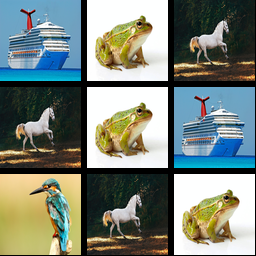

The grid above is size 3 by 3. Each cell contains an object from ['horse', 'bird', 'frog', 'ship'].


[['ship', 'frog', 'horse'],
 ['horse', 'frog', 'ship'],
 ['bird', 'horse', 'frog']]

In [6]:
# Testing to see if everything works 

randint = random.randint(0, 10000)
random_image = Image.open(f"/data/lmm/generated/v3_spatial_grid_multimodal/images/train_{randint}.png")

image_tensor = image_transforms(random_image).unsqueeze(0)
print(image_tensor.shape)

display(random_image)
print(dataset['train'][randint]["prompt"])
parse_grid(dataset['train'][randint]["text"], 3)

In [9]:
# Linear layer
class LinearLayer(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearLayer, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
lm_model.to(device)

image_tensors = []
correct_labels = []

for i in range(100):
    # Load and transform the image
    image = Image.open(f"/data/lmm/generated/v3_spatial_grid_multimodal/images/train_{i}.png")
    image_tensor = image_transforms(image).unsqueeze(0).to(device)  # Move image tensor to GPU
    image_tensor = encoder(image_tensor)  # Process with the encoder
    
    image_tensors.append(image_tensor)

    temp = []
    grid = parse_grid(dataset['train'][i]["text"], 3)
    for row in grid:
        for cell in row:
            temp.append(cell)

    tokens = vlm_tokenizer(temp, return_tensors="pt").to(device)
    with torch.no_grad():
        clear_outputs = lm_model(**tokens, output_hidden_states=True)

    hidden_states = clear_outputs.hidden_states
    embeddings = hidden_states[-1]
    correct_labels.append(embeddings)

In [37]:
print(image_tensors[99].shape)
print(correct_labels[99].shape)

torch.Size([1, 50, 768])
torch.Size([9, 1, 768])


In [67]:
len(image_tensors)

100

In [127]:
# The corresponding tensors for each image, 0 is excluded since I think it is the CLS token
patches = [[1, 2, 3, 8, 9, 10, 15, 16, 17], [3, 4, 5, 10 , 11, 12, 17, 18, 19], [5, 6, 7, 12, 13, 14, 19, 20, 21],
           [15, 16, 17, 22, 23, 24, 29, 30, 31], [17, 18, 19, 24, 25, 26, 31, 32, 33], [19, 20, 21, 26, 27, 28, 33, 34, 35],
           [29, 30, 31, 36, 37, 38, 43, 44, 45], [31, 32, 33, 38, 39, 40, 45, 46, 47], [33, 34, 35, 40, 41, 42, 47, 48, 49]]

prelinear = []

for tensor in image_tensors:
    temp = []
    for position in patches:
        temp.append(torch.cat([tensor[0][i] for i in position], dim = 0))

    prelinear.append(torch.stack(temp).unsqueeze(0)) 

In [138]:
# Each of the 9 images have the 9 associated patches concatenated into a single tensor
prelinear[0].shape

torch.Size([1, 9, 6912])

In [142]:
linear = LinearLayer(6912, 768)
linear.to(device)  

LinearLayer(
  (linear): Linear(in_features=6912, out_features=768, bias=True)
)

In [147]:
testing = linear(prelinear[0])
testing.shape

torch.Size([1, 9, 768])

In [219]:
prelinear[0].shape
prelinear_stack = torch.stack(prelinear, dim = 1)
prelinear_stack.squeeze(0).shape

torch.Size([100, 9, 6912])

In [220]:
for i in range(100):
    correct_labels[i] = correct_labels[i].squeeze(1)

correct_labels_stack = torch.stack(correct_labels, dim = 0)
correct_labels_stack.shape

torch.Size([100, 9, 768])

In [208]:
model = linear
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

total_loss = 0
previous = prelinear_stack.squeeze(0).to(device)
ground_truth = correct_labels_stack.squeeze(1).to(device)

for epoch in range(5):
    model.train()
    epoch_loss = 0

    for i in range(100):
        embedings = previous[i]
        target = ground_truth[i]

        predictions = model(embedings)

        loss = criterion(predictions, target)
        epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

total_loss += epoch_loss
print(f"Epoch {epoch + 1}, Loss: {total_loss}")


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.